In [84]:
# All necessary import 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

In [85]:
# Let's get our data
KDDtrain_path = 'nsl-kdd\KDDTrain+.txt'
KDDtest_path = 'nsl-kdd\KDDTest+.txt'

KDDtrain_df = pd.read_csv(KDDtrain_path, header=None)
KDDtest_df = pd.read_csv(KDDtest_path,header=None)

# Let's concatenate both dataframes
KDD_df = pd.concat([KDDtrain_df, KDDtest_df],ignore_index=True)


In [86]:
# The data doesn't have a header let's take care of it
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])


In [87]:
# Let's assign the name of the columns
KDD_df.columns = columns


In [88]:
# Let's do the same for our test data.
KDDtest_df.columns = columns

# Data preprocessing

In [89]:
# Scaler function

def Scaling(df_num, cols):
    std_scaler = RobustScaler()     #We used robust for it's resilience to outliers and preservation of outlier information
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [90]:
# Preprocessing function

cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome'] # catergorical columns
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)   # leaving only numeric data before scaling
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0  # outcome label 0 for normal network activity
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1 # outcome label 1 for attack or suspicious activity
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag']) # One hot encoding the non numeric categorical data
    return dataframe
# One-hot encoding creates binary columns for each category within the categorical variables, expanding the dataset.
# We will later use PCA (Principal Component Analysis) for dimensionality reduction.

In [91]:
scaled_train = preprocess(KDD_df) 

In [92]:
# Dimensionality reduction

x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values


# Principal Component Analysis
pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

# Data splitting
y = y.astype('int') # Target needs to be an integer
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


# Machine learning approach

In [93]:
# Evaluation function
kernal_evals = dict()   # Dictionary to store the evaluation metrics

def evaluate_classification(model, name, X_train, X_test, y_train, y_test):

    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    train_f1 = metrics.f1_score(y_train, model.predict(X_train))
    test_f1 = metrics.f1_score(y_test, model.predict(X_test))

    # Adding the evaluation metrics to the dictionary
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, train_f1, test_f1]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    print("Training F1 Score " + str(name) + " {}  Test F1 Score ".format(train_f1*100) + str(name) + " {}".format(test_f1*100))

    # Plotting the confusion matrix
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(6,6))
    ax.grid(False)
    cm_display.plot(ax=ax)

### For this notebook let's try some machine learning classifiers and see how they perform on the data. We will use the following classifiers:

* *logistic regression*
* *decision tree*
* *random forest*
* *linear support vector machine*
* *naive bayes*
* *K-nearest neighbors*

c:\Users\youss\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy Logistic Regression 86.74724146347621  Test Accuracy Logistic Regression 86.11971451656343
Training Precesion Logistic Regression 87.6368389521268  Test Precesion Logistic Regression 86.89097662224164
Training Recall Logistic Regression 84.38008005733364  Test Recall Logistic Regression 83.70282026097937
Training F1 Score Logistic Regression 85.97762975100632  Test F1 Score Logistic Regression 85.26710737895303


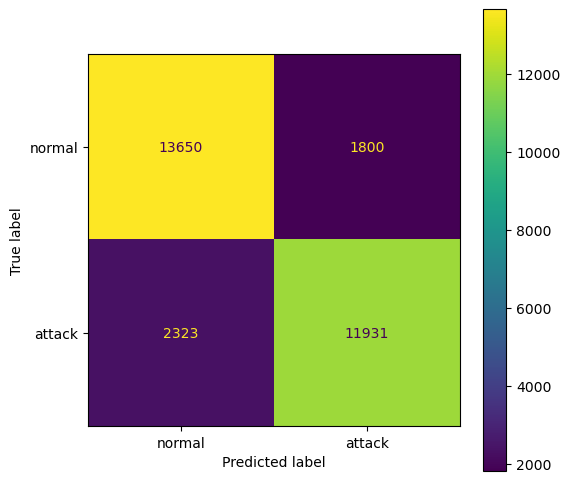

In [94]:
# Logistic Regression

lr = LogisticRegression().fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)

Training Accuracy GaussianNB 84.785334938096  Test Accuracy GaussianNB 84.16711553999461
Training Precesion GaussianNB 91.82735473940741  Test Precesion GaussianNB 90.93870552936134
Training Recall GaussianNB 75.08433987659285  Test Recall GaussianNB 74.4212150975165
Training F1 Score GaussianNB 82.61609624279959  Test F1 Score GaussianNB 81.85500983834253


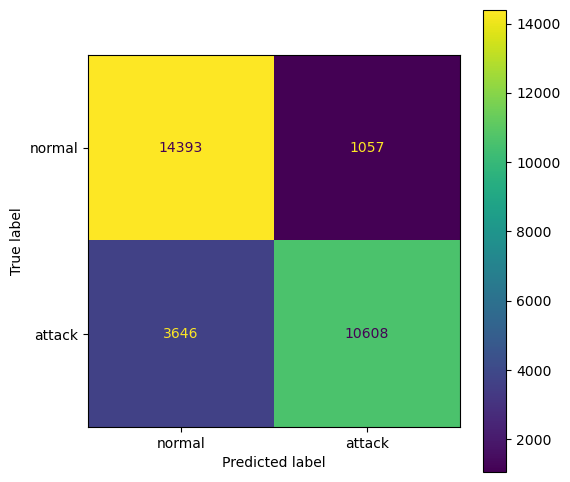

In [95]:
# Gaussian Naive Bayes

gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)

c:\Users\youss\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\youss\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(LBasedImpl) 94.80780722648196  Test Accuracy Linear SVC(LBasedImpl) 94.51925666576892
Training Precesion Linear SVC(LBasedImpl) 95.86628324946082  Test Precesion Linear SVC(LBasedImpl) 95.61416184971098
Training Recall Linear SVC(LBasedImpl) 93.23707808211995  Test Recall Linear SVC(LBasedImpl) 92.83709835835555
Training F1 Score Linear SVC(LBasedImpl) 94.53340304300437  Test F1 Score Linear SVC(LBasedImpl) 94.20516836335162


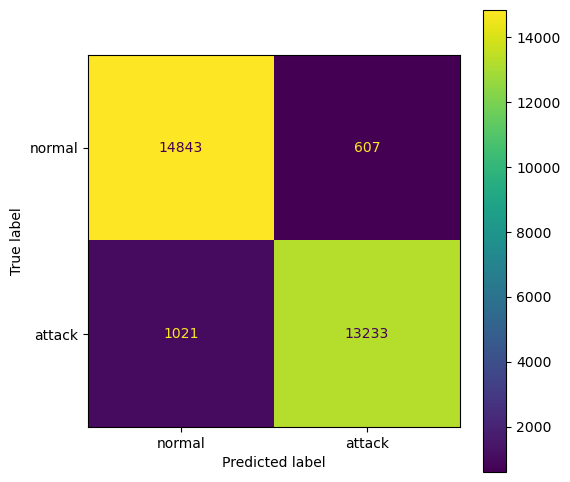

In [96]:
#Linear Support Vector Classifier

lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)

Training Accuracy DecisionTreeClassifier 99.94276720560882  Test Accuracy DecisionTreeClassifier 99.4882844061406
Training Precesion DecisionTreeClassifier 99.99650013124509  Test Precesion DecisionTreeClassifier 99.57114735658043
Training Recall DecisionTreeClassifier 99.88463353668129  Test Recall DecisionTreeClassifier 99.36158271362424
Training F1 Score DecisionTreeClassifier 99.94053553002081  Test F1 Score DecisionTreeClassifier 99.46625465271438


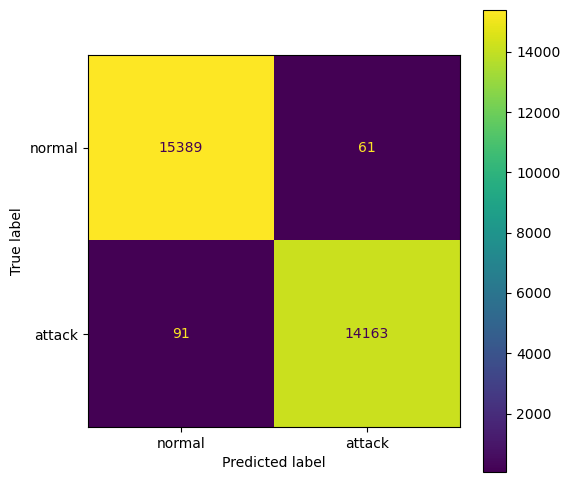

In [97]:
# Decison Tree Classifier

dt = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

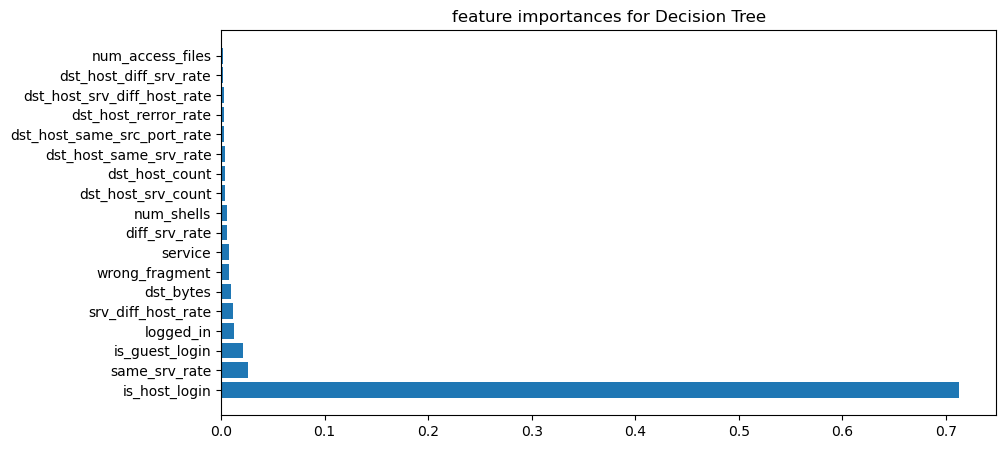

In [98]:
# Visualization is always fun :)

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    
    plt.figure(figsize=(10,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for Decision Tree')
    plt.show()

features_names = KDD_df.drop(['outcome', 'level'] , axis = 1)
f_importances(abs(tdt.feature_importances_), features_names, top=18)

[Text(0.5, 0.875, 'x[5] <= -0.056\ngini = 0.499\nsamples = 118813\nvalue = [61604, 57209]'),
 Text(0.25, 0.625, 'x[65] <= 0.5\ngini = 0.141\nsamples = 54063\nvalue = [4131, 49932]'),
 Text(0.125, 0.375, 'x[6] <= 0.234\ngini = 0.065\nsamples = 50308\nvalue = [1680, 48628]'),
 Text(0.0625, 0.125, 'gini = 0.049\nsamples = 49728\nvalue = [1250, 48478]'),
 Text(0.1875, 0.125, 'gini = 0.383\nsamples = 580\nvalue = [430, 150]'),
 Text(0.375, 0.375, 'x[28] <= -0.009\ngini = 0.453\nsamples = 3755\nvalue = [2451, 1304]'),
 Text(0.3125, 0.125, 'gini = 0.085\nsamples = 2468\nvalue = [2358, 110]'),
 Text(0.4375, 0.125, 'gini = 0.134\nsamples = 1287\nvalue = [93, 1194]'),
 Text(0.75, 0.625, 'x[56] <= 0.5\ngini = 0.2\nsamples = 64750\nvalue = [57473, 7277]'),
 Text(0.625, 0.375, 'x[5] <= 145.761\ngini = 0.134\nsamples = 61757\nvalue = [57286, 4471]'),
 Text(0.5625, 0.125, 'gini = 0.091\nsamples = 59688\nvalue = [56827, 2861]'),
 Text(0.6875, 0.125, 'gini = 0.345\nsamples = 2069\nvalue = [459, 1610]')

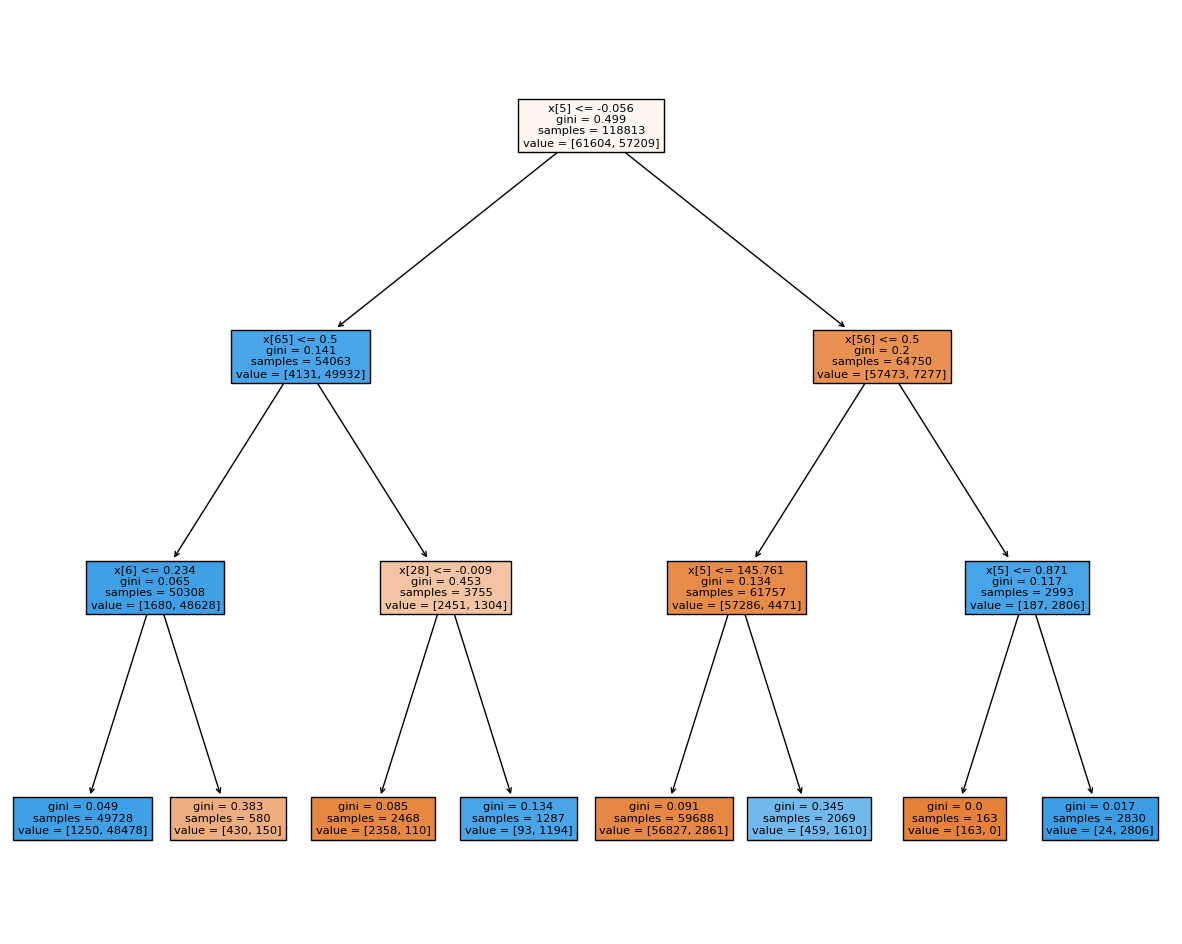

In [99]:
# Even more visualization
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

Training Accuracy RandomForestClassifier 99.94276720560882  Test Accuracy RandomForestClassifier 99.54888230541341
Training Precesion RandomForestClassifier 99.9440608338432  Test Precesion RandomForestClassifier 99.65536643691095
Training Recall RandomForestClassifier 99.9370728381898  Test Recall RandomForestClassifier 99.4036761610776
Training F1 Score RandomForestClassifier 99.94056671386369  Test F1 Score RandomForestClassifier 99.52936218038775


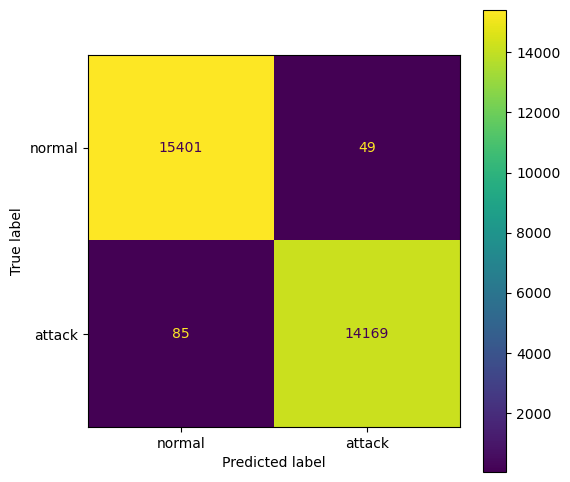

In [100]:
# Random Forest Classifier

rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

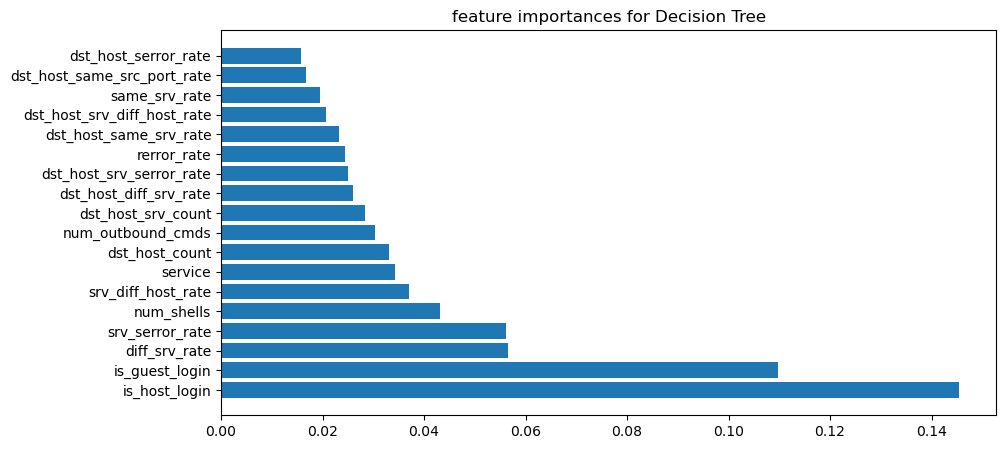

In [101]:
f_importances(abs(rf.feature_importances_), features_names, top=18)